In [257]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer



train_df = pd.read_csv('train.csv')

In [5]:
def filter_data(data, train = True, preprocessor=None):
    training_data = data.copy()
    training_data['NameLength'] = training_data['Name'].str.len()
    training_data[['Deck', 'Num', 'Side']] = training_data['Cabin'].str.split('/', expand=True)
    training_data = training_data.drop(columns=['PassengerId', 'Name', 'Cabin'])

    target = None
    if train:
        target = training_data['Transported']
        training_data = training_data.drop(columns=['Transported'])

    features  = training_data.columns.tolist()
    categorical_features = ['HomePlanet', 'Destination', 'Side', 'Deck']
    numeric_features = [col for col in features if col not in categorical_features]

    for col in ['CryoSleep', 'VIP']:
        training_data[col] = training_data[col].fillna(False).astype(int)

    training_data['Num'] = pd.to_numeric(training_data['Num'], errors='coerce')



    if preprocessor is None:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        X_processed = preprocessor.fit_transform(training_data)

    else:
        # Use passed preprocessor to transform (inference mode)
        X_processed = preprocessor.transform(training_data)

    if train:
        return X_processed, target, preprocessor
    else:
        return X_processed

In [ ]:
def filter_data2(data, train = True, preprocessor=None):
    training_data = data.copy()
    training_data['NameLength'] = training_data['Name'].str.len()
    training_data[['Deck', 'Num', 'Side']] = training_data['Cabin'].str.split('/', expand=True)
#RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
    training_data['total spending'] = training_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1)
    spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_categories:
        training_data[col] = (training_data[col]/training_data['total spending']).fillna(0)

    training_data['Num'] = training_data['Num'].astype(str).str.strip()

    training_data = training_data.drop(columns=['PassengerId', 'Name', 'Cabin'])

    target = None
    if train:
        target = training_data['Transported']
        training_data = training_data.drop(columns=['Transported'])

    features  = training_data.columns.tolist()

    categorical_features = ['HomePlanet', 'Destination', 'Side', 'Deck', 'Num']
    numeric_features = [col for col in features if col not in categorical_features]
    for col in ['CryoSleep', 'VIP']:
        training_data[col] = training_data[col].fillna(False).astype(int)


    if preprocessor is None:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        X_processed = preprocessor.fit_transform(training_data)

    else:
        # Use passed preprocessor to transform (inference mode)
        X_processed = preprocessor.transform(training_data)

    if train:
        return X_processed, target, preprocessor,num_bins_edges
    else:
        return X_processed

In [262]:
def filter_data3(data, train = True, preprocessor=None,num_bins_edges=None):
    training_data = data.copy()
    training_data['NameLength'] = training_data['Name'].str.len()
    training_data[['Deck', 'Num', 'Side']] = training_data['Cabin'].str.split('/', expand=True)
#RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
    training_data['total spending'] = training_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    maxspending = training_data['total spending'].max()
    #training_data['portional_spend'] = training_data['total spending'] / maxspending
    spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_categories:
        training_data[col] = (training_data[col]/training_data['total spending']).fillna(0)

    training_data['Num'] = training_data['Num'].astype(str).str.strip()
    training_data['Num'] = pd.to_numeric(training_data['Num'], errors='coerce')
    if train:
        # Fit bins on training data
        num_bins_edges = pd.qcut(training_data['Num'], q=7, retbins=True, duplicates='drop')[1]
        training_data['NumBin'] = pd.cut(training_data['Num'], bins=num_bins_edges, include_lowest=True).astype(str)
    else:
        # Use passed bin edges to assign bins on test data
        training_data['NumBin'] = pd.cut(training_data['Num'], bins=num_bins_edges, include_lowest=True).astype(str)

    home_planet_map = {'Earth': 0, 'Europa': 1, 'Mars': 2}
    destination_map = {'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2}

    training_data['HomePlanet'] = training_data['HomePlanet'].map(home_planet_map)
    training_data['Destination'] = training_data['Destination'].map(destination_map)

    training_data['sqrt_spend'] = np.sqrt(training_data['total spending'])

    training_data = training_data.drop(columns=['PassengerId', 'Name', 'Cabin', 'Num', 'VIP'])

    target = None
    if train:
        target = training_data['Transported']
        training_data = training_data.drop(columns=['Transported'])

    training_data['combination'] = training_data['Deck'] + training_data['Side']+training_data['NumBin']


    categorical_features = ['Side', 'Deck', 'NumBin', 'combination']
    features  = training_data.columns.tolist()

    for col in training_data.columns:
        if training_data[col].dtype == bool:
            training_data[col] = training_data[col].astype(int)

    numeric_features = [col for col in features if col not in categorical_features]
    for col in ['CryoSleep']:
        training_data[col] = training_data[col].fillna(False).astype(int)




    categorical_features = ['combination']
    training_data = training_data.drop(columns=['Side', 'Deck', 'NumBin'])

    for col in numeric_features:
        Q1 = training_data[col].quantile(0.25)
        Q3 = training_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        training_data[col] = training_data[col].clip(lower=lower_bound, upper=upper_bound)



    if preprocessor is None:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            #('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        X_processed = preprocessor.fit_transform(training_data)

    else:
        # Use passed preprocessor to transform (inference mode)
        X_processed = preprocessor.transform(training_data)

    if train:
        return X_processed, target, preprocessor, num_bins_edges
    else:
        return X_processed

In [224]:
def test_values(y_pred, y_test):
    y_pred = np.array(y_pred)

    # ✅ If shape is (n_samples, 1), flatten it to (n_samples,)
    if y_pred.ndim > 1:
        y_pred = y_pred.ravel()

    # ✅ Only threshold if values are probabilities (i.e. float)
    if y_pred.dtype != int and y_pred.dtype != np.int64:
        y_pred = (y_pred >= 0.5).astype(int)

    np_y_test = np.array(y_test)
    print(np.unique(np_y_test), np_y_test.dtype)
    print(np.unique(y_pred), y_pred.dtype)


    acc = accuracy_score(np_y_test, y_pred)
    prec = precision_score(np_y_test, y_pred)
    rec = recall_score(np_y_test, y_pred)
    f1 = f1_score(np_y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(np_y_test, y_pred))

In [ ]:
train_df, target, preprocessor, num_bins_edges  = filter_data3(train_df, train=True)
#joblib.dump(preprocessor, 'preprocessor.joblib')
X_train, X_test, y_train, y_test = train_test_split(train_df, target, stratify=target, test_size=0.1, random_state=42, shuffle=True)
model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=5, min_samples_split=3,
        min_samples_leaf=2, subsample=0.8, max_features='sqrt', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_values(y_pred, y_test)
joblib.dump(model, 'gradient_boost_model.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')

[False  True] bool
[0 1] int64

Accuracy: 0.8000
Precision: 0.8041
Recall: 0.7968
F1 Score: 0.8005
Confusion Matrix:
 [[347  85]
 [ 89 349]]


['preprocessor.joblib']

In [251]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print("XGBoost accuracy:", model.score(X_test, y_test))


XGBoost accuracy: 0.7919540229885057


In [244]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    model = XGBClassifier(**params, eval_metric='logloss')
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print(study.best_params)


[I 2025-08-05 19:38:53,645] A new study created in memory with name: no-name-81ce05c7-a204-472b-b488-277cb992c0a6
[I 2025-08-05 19:38:56,060] Trial 0 finished with value: 0.8005901146401053 and parameters: {'max_depth': 10, 'learning_rate': 0.04305229705813489, 'n_estimators': 147, 'subsample': 0.6573494162255232, 'colsample_bytree': 0.6690621470463747, 'min_child_weight': 8}. Best is trial 0 with value: 0.8005901146401053.
[I 2025-08-05 19:38:57,953] Trial 1 finished with value: 0.799950810161542 and parameters: {'max_depth': 5, 'learning_rate': 0.09502887692867652, 'n_estimators': 227, 'subsample': 0.9985198367479627, 'colsample_bytree': 0.7386173057457458, 'min_child_weight': 2}. Best is trial 0 with value: 0.8005901146401053.
[I 2025-08-05 19:38:59,842] Trial 2 finished with value: 0.8003335430574507 and parameters: {'max_depth': 5, 'learning_rate': 0.012494767020455171, 'n_estimators': 147, 'subsample': 0.9015306411124723, 'colsample_bytree': 0.8741027994776469, 'min_child_weight'

{'max_depth': 6, 'learning_rate': 0.02151991253830653, 'n_estimators': 216, 'subsample': 0.8392030637899004, 'colsample_bytree': 0.8219128895204542, 'min_child_weight': 3}


In [266]:
best_XGB = XGBClassifier(
    max_depth=6,
    learning_rate=0.02151991253830653,
    n_estimators=216,
    subsample=0.8392030637899004,
    colsample_bytree=0.8219128895204542,
    min_child_weight=3
)
best_XGB.fit(X_train, y_train)
y_pred = best_XGB.predict(X_test)
test_values(y_pred, y_test)

[False  True] bool
[0 1] int64

Accuracy: 0.8000
Precision: 0.7960
Recall: 0.8105
F1 Score: 0.8032
Confusion Matrix:
 [[341  91]
 [ 83 355]]


In [263]:
from sklearn.model_selection import StratifiedKFold


training_df = pd.read_csv('train.csv')
# Assume target is defined, e.g. target = training_df['Transported'] or your label column
target = training_df['Transported'].reset_index(drop=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
oof_preds = np.zeros(len(training_df))  # out-of-fold predictions placeholder

for fold, (train_idx, val_idx) in enumerate(skf.split(training_df, target)):
    print(f'Fold {fold+1}')
    train_data = training_df.iloc[train_idx]
    val_data = training_df.iloc[val_idx]

    # Preprocess training data for this fold
    X_train_fold, y_train_fold, preprocessor, num_bins_edges = filter_data3(train_data, train=True)
    X_val_fold = filter_data3(val_data, train=False, preprocessor=preprocessor, num_bins_edges=num_bins_edges)
    y_val_fold = target.iloc[val_idx]

    model = XGBClassifier(
        max_depth=6,
        learning_rate=0.02,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train_fold, y_train_fold)

    val_preds = model.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, val_preds)
    print(f'Validation accuracy: {acc}')
    accuracies.append(acc)

    # Store OOF predictions
    oof_preds[val_idx] = val_preds

print(f'Mean CV accuracy: {np.mean(accuracies)}')


Fold 1


/Users/The_real_G/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation accuracy: 0.7780333525014376
Fold 2


/Users/The_real_G/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation accuracy: 0.7676825761932144
Fold 3


/Users/The_real_G/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation accuracy: 0.7492811960897068
Fold 4


/Users/The_real_G/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation accuracy: 0.7911392405063291
Fold 5


/Users/The_real_G/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation accuracy: 0.7681242807825086
Mean CV accuracy: 0.7708521292146393


In [226]:
test_df = pd.read_csv('test.csv')



passenger_ids = test_df['PassengerId']
X_test_processed = filter_data3(test_df, train=False, preprocessor=preprocessor, num_bins_edges=num_bins_edges)
predictions = model.predict(X_test_processed)
submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': predictions.astype(bool)
    })
submission.to_csv('submission2.csv', index=False)

                               Feature  Importance
10                 num__total spending    0.237811
11                     num__sqrt_spend    0.157386
5                       num__FoodCourt    0.154482
6                    num__ShoppingMall    0.118099
0                      num__HomePlanet    0.067838
1                       num__CryoSleep    0.055858
73  cat__combination_GS(913.0, 1284.0]    0.023254
8                          num__VRDeck    0.022997
7                             num__Spa    0.022779
3                             num__Age    0.021545
4                     num__RoomService    0.017550
71   cat__combination_GS(556.0, 913.0]    0.010610
9                      num__NameLength    0.009318
38   cat__combination_EP(309.0, 556.0]    0.009039
29    cat__combination_CS(91.0, 193.0]    0.008450
59  cat__combination_FS(913.0, 1284.0]    0.007886
2                     num__Destination    0.007241
57   cat__combination_FS(556.0, 913.0]    0.004639
40    cat__combination_EP(91.0,

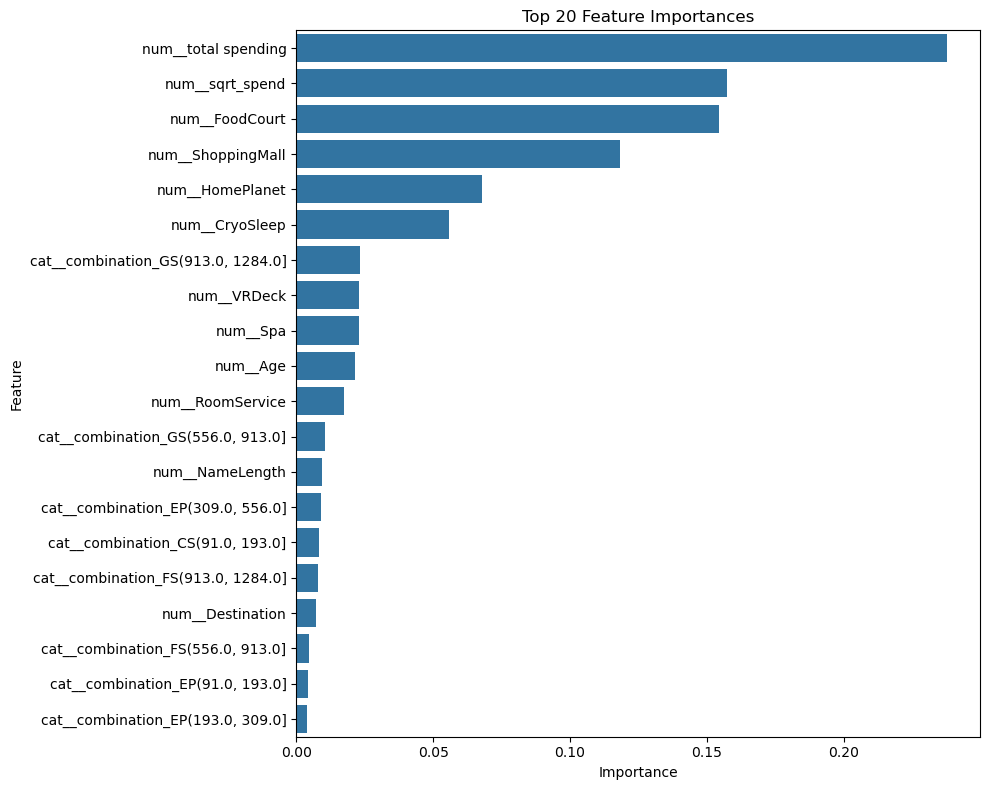

In [153]:
import seaborn as sns

importances = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False).head(20)
print(feature_df)
# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_df)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()